In [91]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, PhyloTree
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

Start with loading the output from `FastTree` and `ClustalO`

In [53]:
tree = PhyloTree(snakemake.input.tree)
annotation = pd.read_csv(snakemake.input.annotation, sep="\t")

Now define the basic tree styles

In [106]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = False
ts.show_branch_support = False
ts.mode = "c"
ts.scale = 100
ts.optimal_scale_level = "full"
ts.extra_branch_line_type = 2
ts.arc_span = 360

ns = NodeStyle()
ns["size"] = 0
ns["vt_line_width"] = 2
ns["hz_line_width"] = 2
ns["vt_line_color"] = "black"
ns["hz_line_color"] = "black"
ns["bgcolor"] = "lightgray"




Define some functions to apply styling

In [ ]:
def apply_style( tree, style ):
    """Apply a style to all nodes in a tree"""
    for n in tree.traverse():
        n.set_style(style)


def cross_ref( tree, df ):
    """Ensure that the annotation does not contain any nodes that are not also in the tree"""
    for idx, line in df.iterrows():
        node = tree.search_nodes(name=line["node"])
        if len(node) == 0:
            df.drop(idx, inplace=True)



def make_color_palette( df, palette ):
    """Make a color palette for the clades"""
    clades = df["clade"].unique()
    colors = sns.color_palette( palette, len(clades), desat = 0.9).as_hex()
    color_dict = dict(zip(clades, colors))
    return color_dict

def color_clades( tree, df, palette = "colorblind" ):
    """Color the clades"""
    color_dict = make_color_palette( df, palette )
    clades = df.groupby("clade")

    for clade, subset in clades:
        nodes = list(subset["node"]) 
        
        for node in nodes:
            n = tree.search_nodes(name=node)
            if len(n) > 0:
                cladestyle = new_cladestyle(color_dict[clade])
                n[0].set_style(cladestyle)

def new_cladestyle( color ):
    """Make a new style for a clade"""
    cladestyle = NodeStyle()
    cladestyle["size"] = 0
    cladestyle["vt_line_width"] = 2
    cladestyle["hz_line_width"] = 2
    cladestyle["vt_line_color"] = color
    cladestyle["hz_line_color"] = color
    cladestyle["bgcolor"] = color
    return cladestyle

def make_dummy_legend( df, palette, ncol = 2 ):
    """Make a dummy legend for the clades to later assemble a proper figure"""
    color_dict = make_color_palette( df, palette )
    clades = df.groupby("clade")
    fig, ax = plt.subplots()
    for clade, subset in clades:
        ax.scatter(0,0, color=color_dict[clade], label=clade)
    
    for s in ("top", "right", "left", "bottom"):
        ax.spines[s].set_visible(False)
        ax.set(xticks=[], yticks=[])
    
    ax.legend(ncol = ncol, bbox_to_anchor=(1,1), title = "Clade") 
    return fig


Now generate the tree figure

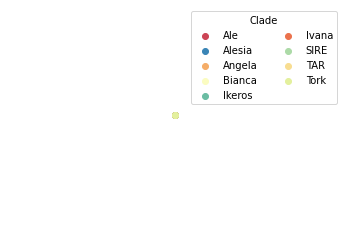

In [107]:

cross_ref(tree, annotation)
apply_style(tree, ns)
color_clades(tree, annotation, snakemake.params.palette)

_ = tree.render(snakemake.output.tree, tree_style=ts, dpi = 300)

fig = make_dummy_legend( annotation, snakemake.params.palette )
fig.savefig(snakemake.output.legend, dpi=300)
    